# Nowcast Library Pipeline - A Tutorial

The Nowcast Library Pipeline is intended as a holistic yet modular system for processing and synchronizing data, fitting models to it, and evaluating these models.

This notebook will provide users with an example of how one may use the library, along with a description of the available functionality.

## Preliminary Notes 

The pipeline is primarily intended to be used via the command line. As such this notebook will mostly make calls to the command line. In Jupyter Notebooks, this is done by adding an exclamation mark prefix to the prompt, as such:

---

In [1]:
!nowcastlib -h

usage: nowcastlib [-h] [-v]
                  {triangulate,preprocess,sync,postprocess,splitprocess,datapipe}
                  ...

positional arguments:
  {triangulate,preprocess,sync,postprocess,splitprocess,datapipe}
                        available commands
    triangulate         Run `nowcastlib triangulate -h` for further help
    preprocess          Run `nowcastlib preprocess -h` for further help
    sync                Run `nowcastlib sync -h` for further help
    postprocess         Run `nowcastlib postprocess -h` for further help
    splitprocess        Run `nowcastlib splitprocess -h` for further help
    datapipe            Run `nowcastlib datapipe -h` for further help

optional arguments:
  -h, --help            show this help message and exit
  -v, --verbose         increase verbosity level from INFO to DEBUG


---
Users should therefore take note not to copy the exclamation mark when copying with the intention of pasting example prompts into their own terminal.

## Configuration

If we ask for help with any of the pipeline cli commands, we will notice that the pipeline only takes a single argument to run:

---

In [2]:
!nowcastlib datapipe -h

usage: nowcastlib datapipe [-h] -c CONFIG

Run the data-wrangling pipeline step: Preprocessing, Synchronization and
Postprocessing

optional arguments:
  -h, --help            show this help message and exit
  -c CONFIG, --config CONFIG
                        path to JSON file following the DataSet format. See
                        docs for available fields


---

Namely `-c` or `--config`, the path to a JSON file containing the desired configuration for our pipeline command.

The "schema" for this configuration file can be inferred from the custom classes or "structs" defined in the nowcastlib.pipeline.structs.config submodule, with documentation available [here](https://www.giuliostarace.com/nowcastlib/pipeline/structs/config). 

Any JSON configuration will essentially be a representation of an instance of the `DataSet` class, with additional sub-classes (for more granular configuration) defined within.

## Example Config

Let's explore the available configuration options by gradually building a `DataSet` JSON object. If we look at the `DataSet` class we see that we can represent a (very bare) `DataSet` instance with the following JSON:

```JSON
{
    "data_sources":[],
    "sync_options":null,
    "postprocessing_output":null,
    "split_options": null,
    "generated_fields": null
}
```

### DataSources

Any `DataSet` instance will need to list the `DataSource`s comprising it. This is specified via the `data_sources` key. The other keys are for additional 
configuration, which the user may even omit (omitting will default them to null, or `NoneType` as referred to in the documentation). We will get to these later. 

Let's start by specifying two data sources, La Silla DIMM and La Silla Meteo.

```JSON
{
    "data_sources": [
        {
            "name": "lso_dimm",
            "path": "data/LSO/lasilla_dimm.csv",
            "fields": [],
            "comment_format": "#",
        },
        {
            "name": "lso_meteo",
            "path": "data/LSO/lasilla_meteo.csv",
            "fields": [],
            "comment_format": "#",
        },
    ],
}
```

### RawFields

For each `DataSource`, we then also have to specify what fields (columns) we are interested in, and what to do with them. We do this by listing `RawField` objects under the `fields` key of each `DataSource`:

```JSON
{
   "data_sources":[
      {
         "name":"lso_dimm",
         "path":"data/LSO/lasilla_dimm.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"DIMM Seeing [arcsec]"
            }
         ],
         "comment_format":"#"
      },
      {
         "name":"lso_meteo",
         "path":"data/LSO/lasilla_meteo.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"Wind Speed at 10m [m/s]"
            },
            {
               "field_name":"Wind Direction at 10m [deg]"
            }
         ],
         "comment_format":"#"
      }
   ]
}
```

### Preprocessing

For the moment, we are simply specifying the field name in the csv file, and whether the field is the date to be used as the index.

We can now start specifying how we wish to preprocess each `RawField` entry with the `preprocessing_options` key. 

For conciseness, we will use the "DIMM Seeing [arcsec]" field as an example and omit adding further configuration to the other fields, but in practice one may very well choose to process all fields.

Omitting further configuration is equivalent to setting the respective keys their default, which is often `null` (or `None` in Python). In general, when keys are `null` or omitted, this signals to the pipeline that the user is not interested in running the relevant processing steps for that field. Users should check the documentation about specific default behavior of each key.

```JSON
{
   "data_sources":[
      {
         "name":"lso_dimm",
         "path":"data/LSO/lasilla_dimm.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"DIMM Seeing [arcsec]",
               "preprocessing_options":{
                  "overwrite":false,
                  "outlier_options":{
                     "lower":0,
                     "upper":5,
                     "quantile_based":false
                  }
               }
            }
         ],
         "comment_format":"#"
      },
      {
         "name":"lso_meteo",
         "path":"data/LSO/lasilla_meteo.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"Wind Speed at 10m [m/s]"
            },
            {
               "field_name":"Wind Direction at 10m [deg]"
            }
         ],
         "comment_format":"#"
      }
   ]
}
```

We have added some preprocessing options to the "DIMM Seeing [arcsec]" field. 

- We set `overwrite` to `false` (although this is the default). The original column will be maintained in the data and a new column of the same name prefixed with "processed_" will be created. If we had set `overwrite` to `true`, the original column would have been overwritten.
- With the `outlier_options` key we are filtering "outliers" by specifying the allowed range of values that the field may have. We are doing so in absolute terms since we have set `quantile_based` to `false`. Alternatively we may have decided that we only wanted to keep the bottom 99.9999% of the data, in which case we would have set `quantile_based` to `true` and `upper` to `0.999999`.
- We do not handle any periodicity with `periodic_options` because our quantity is not periodic in nature. Had we been dealing with for example Wind Direction, we may have wanted our values to be limited to the range `[0, 360[`, such that values of `361` would be mapped to `1` for example. An example `periodic_options` configuration for the above may have looked like:
    ```JSON
    {
    "period_length":360
    }
    ```
- We do not perform any unit conversion with `conversion_options` since we are happy with our current units. An example `conversion_options` configuration for converting from miles per hour to meters per second may have looked like:
    ```JSON
    {
        "key":"mph2ms"
    }
    ```
- We do not perform any smoothing by omitting the `smoothing_options` key. This is simply because in this notebook this will be peformed in postprocessing. Users may decide to perform smoothing in preprocessing although this is generally not suggested.

#### Preprocessing Serialization

The pipeline can also be used to perform only data preprocessing. In this case the user will probably wish to serialize (save to disk) the preprocessing results. This is done by configuring the `preprocessing_output` key for any `DataSource` whose preprocessing results we wish to serialize. 

Since we are only preprocessing the "lso_dimm" data source, let's go ahead and serialize only that:

```JSON
{
   "data_sources":[
      {
         "name":"lso_dimm",
         "path":"data/LSO/lasilla_dimm.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"DIMM Seeing [arcsec]",
               "preprocessing_options":{
                  "overwrite":false,
                  "outlier_options":{
                     "lower":0,
                     "upper":5,
                     "quantile_based":false
                  }
               }
            }
         ],
         "comment_format":"#",
         "preprocessing_output":{
            "output_format":"csv",
            "output_path":"output/example_datapipe/preproc_lso_dimm.csv"
         }
      },
      {
         "name":"lso_meteo",
         "path":"data/LSO/lasilla_meteo.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"Wind Speed at 10m [m/s]"
            },
            {
               "field_name":"Wind Direction at 10m [deg]"
            }
         ],
         "comment_format":"#"
      }
   ]
}
```

Running preprocessing with the above config should therefore result in a csv file containing the processed "lso_dimm" data.

#### Preprocessing Example run

Let's save the above config to the file `tutorial_pipeline_preprocess.json` and run a preprocessing pipeline. We will use the `-v` flag for additional verbosity.

---

In [3]:
!nowcastlib -v preprocess -c tutorial_pipeline_preprocess.json

2021-08-25 21:18:36,432 - INFO - Preprocessing dataset...
2021-08-25 21:18:36,432 - DEBUG - Preprocessing lso_dimm...
2021-08-25 21:18:36,432 - DEBUG - Reading file...
2021-08-25 21:18:38,210 - DEBUG - Processing field Date time of lso_dimm...
2021-08-25 21:18:38,210 - DEBUG - Processing field DIMM Seeing [arcsec] of lso_dimm...
2021-08-25 21:18:38,242 - DEBUG - Dropping outliers...
2021-08-25 21:18:38,371 - DEBUG - Dropping NaNs...
2021-08-25 21:18:38,429 - DEBUG - Serializing preprocessing output...
2021-08-25 21:18:44,583 - DEBUG - Preprocessing lso_meteo...
2021-08-25 21:18:44,583 - DEBUG - Reading file...
2021-08-25 21:18:54,242 - DEBUG - Processing field Date time of lso_meteo...
2021-08-25 21:18:54,243 - DEBUG - Processing field Wind Speed at 10m [m/s] of lso_meteo...
2021-08-25 21:18:54,243 - DEBUG - Processing field Wind Direction at 10m [deg] of lso_meteo...
2021-08-25 21:18:54,243 - DEBUG - Dropping NaNs...
2021-08-25 21:18:54,399 - INFO - Dataset preprocessing complete.


---

As we can see, the pipeline correctly preprocessed the "lso_dimm" DataSource as configured, dropping outliers and serializing the resulting output.

Let's read the serialized output and check it.

In [4]:
import pandas as pd

In [5]:
preproc_lso_dimm = pd.read_csv(
    "output/example_datapipe/preproc_lso_dimm.csv",
    parse_dates=True,
    index_col="Date time",
)

In [6]:
preproc_lso_dimm

,DIMM Seeing [arcsec],processed_DIMM Seeing [arcsec]
Date time,,
2005-04-19 00:26:20,2.03,2.03
2005-04-19 00:27:20,2.12,2.12
2005-04-19 00:28:20,3.13,3.13
2005-04-19 00:29:20,2.47,2.47
2005-04-19 00:30:20,2.73,2.73
...,...,...
2021-03-28 23:30:37,1.25,1.25
2021-03-28 23:31:37,1.41,1.41
2021-03-28 23:32:37,1.30,1.30


The serialization was successful. We can also see that the overwriting config was also successfully parsed given the creation of the new column. Finally we can check that our outlier configuration was respected by checking the statistics of our processed column:

In [7]:
preproc_lso_dimm["processed_DIMM Seeing [arcsec]"].describe()

count    1.256461e+06
mean     1.027188e+00
std      4.197804e-01
min      0.000000e+00
25%      7.400000e-01
50%      9.400000e-01
75%      1.220000e+00
max      4.990000e+00
Name: processed_DIMM Seeing [arcsec], dtype: float64

<AxesSubplot:>

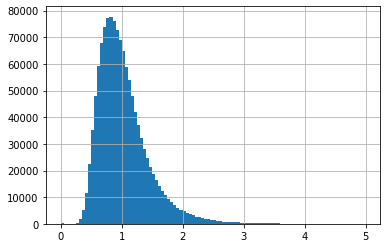

In [8]:
preproc_lso_dimm["processed_DIMM Seeing [arcsec]"].hist(bins=100)

As we can see, the data outside the range `[0, 5]` has been removed, as configured.

### Synchronization

Since we have specified more than one `DataSource` in our configuration, we can also perform _synchronization_. This is the process of aligning two or more `DataSource`s in time, matching them to a single sample-rate and only keeping chunks of data where there is complete overlap across all `DataSource`s.

To synchronize our data we need to configure the `sync_options` key of our JSON configuration at the top level:

```JSON
{
   "sync_options":{
      "sample_spacing":60,
      "chunk_options":{
         "max_gap_size":600,
         "min_chunk_size":3600
      },
      "diagnostic_plots":false
   },
   "data_sources":[
      {
         "name":"lso_dimm",
         "path":"data/LSO/lasilla_dimm.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"DIMM Seeing [arcsec]",
               "preprocessing_options":{
                  "overwrite":false,
                  "outlier_options":{
                     "lower":0,
                     "upper":5,
                     "quantile_based":false
                  }
               }
            }
         ],
         "comment_format":"#",
         "preprocessing_output":{
            "output_format":"csv",
            "output_path":"output/example_datapipe/preproc_lso_dimm.csv"
         }
      },
      {
         "name":"lso_meteo",
         "path":"data/LSO/lasilla_meteo.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"Wind Speed at 10m [m/s]"
            },
            {
               "field_name":"Wind Direction at 10m [deg]"
            }
         ],
         "comment_format":"#"
      }
   ]
}
```

The contents of the `sync_options` key is a JSON representation of a `SyncOptions` struct.

- Our `DataSource`s may have different sample rates, and as such need to be
  resampled to the same sample rate to facilitate synchronization. We specify
  this 'target' sample rate by setting the `sample_spacing` option. Here we
  have set it to 60 seconds.
- Setting `diagnostic_plots` to `true` will have the pipeline prompt the user
  to confirm their selected sample spacing after viewing a plot of the
  distributions of sample spacings of each `DataSource`. Because we are
  running the pipeline as a terminal command from within Jupyter, interactive
  plots cannot be shown, and as such it is set to `false`.
- Because synchronization can often results in "chunks", contiguous portions
  of data delimited by `NaN` gaps, the user is also required to specify
  `chunk_options`:
    - There may be instances where the gaps between data points are
      sufficiently small to be imputed with linear interpolation. The
      `max_gap_size` sets the upper limit on these small gaps. In our example,
      any gap smaller than 10 minutes (600 seconds) will be imputed via linear
      interpolation
   -  Certain chunks may be too small to be considered. In this case the user
      may wish to ignore them. The lower limit for a chunk size can therefore
      be set with `min_chunk_size`. In our example, any chunk shorter than 1
      hour (3600 seconds) will be ignored. 

#### Synchronization Example Run 1

At this point, we may run a synchronization process. However, with the current configuration, this will also run preprocessing on our `lso_dimm` `DataSource`. Let's save the JSON above to the file `tutorial_pipeline_sync_with_preprocess.json` and have a look. We once again use the `-v` flag for extra verbosity.

---

In [9]:
!nowcastlib -v sync -c tutorial_pipeline_sync_with_preprocess.json

2021-08-25 21:18:59,521 - INFO - Preprocessing dataset...
2021-08-25 21:18:59,521 - DEBUG - Preprocessing lso_dimm...
2021-08-25 21:18:59,521 - DEBUG - Reading file...
2021-08-25 21:19:01,010 - DEBUG - Processing field Date time of lso_dimm...
2021-08-25 21:19:01,010 - DEBUG - Processing field DIMM Seeing [arcsec] of lso_dimm...
2021-08-25 21:19:01,047 - DEBUG - Dropping outliers...
2021-08-25 21:19:01,194 - DEBUG - Dropping NaNs...
2021-08-25 21:19:01,272 - DEBUG - Serializing preprocessing output...
2021-08-25 21:19:08,054 - DEBUG - Preprocessing lso_meteo...
2021-08-25 21:19:08,054 - DEBUG - Reading file...
2021-08-25 21:19:17,924 - DEBUG - Processing field Date time of lso_meteo...
2021-08-25 21:19:17,924 - DEBUG - Processing field Wind Speed at 10m [m/s] of lso_meteo...
2021-08-25 21:19:17,924 - DEBUG - Processing field Wind Direction at 10m [deg] of lso_meteo...
2021-08-25 21:19:17,924 - DEBUG - Dropping NaNs...
2021-08-25 21:19:18,067 - INFO - Dataset preprocessing complete.
202

---

As we can see, both preprocessing and synchronization were performed. There was also no serialization of our synchronization output, so that is not of much use to us.

#### Synchronization Example Run 2

To avoid preprocessing, we simply need to remove any preprocessing configuration from our config file. 

```JSON
{
   "sync_options":{
      "sample_spacing":60,
      "chunk_options":{
         "max_gap_size":600,
         "min_chunk_size":3600
      },
      "diagnostic_plots":false
   },
   "data_sources":[
      {
         "name":"lso_dimm",
         "path":"data/LSO/lasilla_dimm.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"DIMM Seeing [arcsec]"
            }
         ],
         "comment_format":"#"
      },
      {
         "name":"lso_meteo",
         "path":"data/LSO/lasilla_meteo.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"Wind Speed at 10m [m/s]"
            },
            {
               "field_name":"Wind Direction at 10m [deg]"
            }
         ],
         "comment_format":"#"
      }
   ]
}
```

The output of our synchronization process is a sparse pandas dataframe with the aligned data and a numpy array of shape (-1, 2) with the start and end indices of each chunk. We can serialize these objects using the `data_output` and `chunks_output` keys respectively, which both consist in a `SerializationOptions` struct.

```JSON
{
   "sync_options":{
      "sample_spacing":60,
      "chunk_options":{
         "max_gap_size":600,
         "min_chunk_size":3600
      },
      "diagnostic_plots":false,
      "data_output":{
         "output_format":"pickle",
         "output_path":"output/example_datapipe/synced_df.pkl"
      },
      "chunks_output":{
         "output_format":"npy",
         "output_path":"output/example_datapipe/chunk_locs.npy"
      }
   },
   "data_sources":[
      {
         "name":"lso_dimm",
         "path":"data/LSO/lasilla_dimm.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"DIMM Seeing [arcsec]"
            }
         ],
         "comment_format":"#"
      },
      {
         "name":"lso_meteo",
         "path":"data/LSO/lasilla_meteo.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"Wind Speed at 10m [m/s]"
            },
            {
               "field_name":"Wind Direction at 10m [deg]"
            }
         ],
         "comment_format":"#"
      }
   ]
}
```

Now that we're all set, let's save the JSON above to the file `tutorial_pipeline_sync.json` and try again:

---

In [10]:
!nowcastlib -v sync -c tutorial_pipeline_sync.json

2021-08-25 21:19:32,981 - INFO - Preprocessing dataset...
2021-08-25 21:19:32,981 - DEBUG - Preprocessing lso_dimm...
2021-08-25 21:19:32,982 - DEBUG - Reading file...
2021-08-25 21:19:34,287 - DEBUG - Processing field Date time of lso_dimm...
2021-08-25 21:19:34,287 - DEBUG - Processing field DIMM Seeing [arcsec] of lso_dimm...
2021-08-25 21:19:34,287 - DEBUG - Dropping NaNs...
2021-08-25 21:19:34,313 - DEBUG - Preprocessing lso_meteo...
2021-08-25 21:19:34,313 - DEBUG - Reading file...
2021-08-25 21:19:42,684 - DEBUG - Processing field Date time of lso_meteo...
2021-08-25 21:19:42,684 - DEBUG - Processing field Wind Speed at 10m [m/s] of lso_meteo...
2021-08-25 21:19:42,684 - DEBUG - Processing field Wind Direction at 10m [deg] of lso_meteo...
2021-08-25 21:19:42,684 - DEBUG - Dropping NaNs...
2021-08-25 21:19:42,822 - INFO - Dataset preprocessing complete.
2021-08-25 21:19:42,822 - INFO - Synchronizing dataset...
2021-08-25 21:19:42,822 - DEBUG - Resampling DataSource 1 of 2...
2021

---

As we can see from the logs, "preprocessing" here simply consisted in reading the raw data and dropping NaNs. Synchronization was performed once again but this time we have serialized files that we can check.

In [11]:
synced_df = pd.read_pickle("output/example_datapipe/synced_df.pkl")

In [12]:
synced_df

,DIMM Seeing [arcsec],Wind Direction at 10m [deg],Wind Speed at 10m [m/s]
2005-04-19 00:26:00,NaN,NaN,NaN
2005-04-19 00:27:00,NaN,NaN,NaN
2005-04-19 00:28:00,NaN,NaN,NaN
2005-04-19 00:29:00,NaN,NaN,NaN
2005-04-19 00:30:00,NaN,NaN,NaN
...,...,...,...
2021-03-29 01:01:00,NaN,NaN,NaN
2021-03-29 01:02:00,NaN,NaN,NaN
2021-03-29 01:03:00,NaN,NaN,NaN
2021-03-29 01:04:00,NaN,NaN,NaN


In [13]:
import numpy as np

In [14]:
chunk_locs = np.load("output/example_datapipe/chunk_locs.npy")

In [15]:
chunk_locs

array([[     52,     143],
       [    170,     507],
       [   1560,    1932],
       ...,
       [8382631, 8382758],
       [8383719, 8383858],
       [8384028, 8384186]])

We can now for example break our `synced_df` into an array of non-sparse dataframes using `nowcastlib.datasets`, with our pre-computed `chunk_locs` to speed up the process.

In [16]:
from nowcastlib.datasets import make_chunks

In [17]:
chunks = make_chunks(synced_df, chunk_locs)

In [18]:
# showing an arbitrary chunk
chunks[30]

,DIMM Seeing [arcsec],Wind Direction at 10m [deg],Wind Speed at 10m [m/s]
2005-05-13 22:30:00,2.080,14.0,1.2
2005-05-13 22:31:00,2.180,14.0,1.2
2005-05-13 22:32:00,2.370,14.0,1.4
2005-05-13 22:33:00,1.960,14.0,1.6
2005-05-13 22:34:00,2.180,14.0,1.6
...,...,...,...
2005-05-14 03:16:00,1.295,4.0,5.3
2005-05-14 03:17:00,1.350,4.0,5.3
2005-05-14 03:18:00,1.350,4.0,5.3
2005-05-14 03:19:00,1.350,4.0,5.3


### Postprocessing

After preprocessing and synchronization, the user may be interested in postprocessing the data with additional operations and the generation of new fields.

We can add some basic postprocessing to our data. We do this in the same way as we did for preprocessing, i.e. by adding a `postprocessing_options` key to each of the `RawFields` that we wish to postprocess. These postprocessing options are the same as those for preprocessing, except they are performed after synchronization. As always let's focus on the "lso_dimm" `DataSource` to keep things simple.

To keep things a bit more concise, the serialization options for syncing and the preprocessing options from previous example configs have been removed.

```JSON
{
   "sync_options":{
      "sample_spacing":60,
      "chunk_options":{
         "max_gap_size":600,
         "min_chunk_size":3600
      },
      "diagnostic_plots":false
   },
   "data_sources":[
      {
         "name":"lso_dimm",
         "path":"data/LSO/lasilla_dimm.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"DIMM Seeing [arcsec]",
                "postprocessing_options":{
                  "smooth_options":{
                     "window_size":10,
                     "units":"min"
                  }
               }
            }
         ],
         "comment_format":"#"
      },
      {
         "name":"lso_meteo",
         "path":"data/LSO/lasilla_meteo.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"Wind Speed at 10m [m/s]"
            },
            {
               "field_name":"Wind Direction at 10m [deg]"
            }
         ],
         "comment_format":"#"
      }
   ]
}
```

We have configured our pipeline so that it will postprocess the "DIMM Seeing [arcsec]" `RawField` of the "lso_dimm" `DataSource` by applying a 10 minute moving average for smoothing.

#### Postprocessing Serialization

Just like with preprocessing, the user will probably wish to serialize (save to disk) the postprocessing results. This is done by configuring the `postprocessing_output` key for our `DataSet`, since in postprocessing the dataset is treated as a whole.

```JSON
{
   "postprocessing_output":{
       "output_format":"pickle",
       "output_path":"output/example_datapipe/postprocessed_df.pkl"
   },
   "sync_options":{
      "sample_spacing":60,
      "chunk_options":{
         "max_gap_size":600,
         "min_chunk_size":3600
      },
      "diagnostic_plots":false,
   },
   "data_sources":[
      {
         "name":"lso_dimm",
         "path":"data/LSO/lasilla_dimm.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"DIMM Seeing [arcsec]",
                "postprocessing_options":{
                  "smooth_options":{
                     "window_size":10,
                     "units":"min"
                  }
               }
            }
         ],
         "comment_format":"#"
      },
      {
         "name":"lso_meteo",
         "path":"data/LSO/lasilla_meteo.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"Wind Speed at 10m [m/s]"
            },
            {
               "field_name":"Wind Direction at 10m [deg]"
            }
         ],
         "comment_format":"#"
      }
   ]
}
```

Running postprocessing with the above config should therefore result in a pkl file containing the postprocessed dataframe.

#### Postprocessing Example Run 1

Let's save the above config to the file `tutorial_pipeline_postprocess.json` and run a postprocessing pipeline.

---

In [19]:
!nowcastlib -v postprocess -c tutorial_pipeline_postprocess.json

2021-08-25 21:19:57,016 - INFO - Preprocessing dataset...
2021-08-25 21:19:57,016 - DEBUG - Preprocessing lso_dimm...
2021-08-25 21:19:57,016 - DEBUG - Reading file...
2021-08-25 21:19:58,459 - DEBUG - Processing field Date time of lso_dimm...
2021-08-25 21:19:58,459 - DEBUG - Processing field DIMM Seeing [arcsec] of lso_dimm...
2021-08-25 21:19:58,459 - DEBUG - Dropping NaNs...
2021-08-25 21:19:58,492 - DEBUG - Preprocessing lso_meteo...
2021-08-25 21:19:58,492 - DEBUG - Reading file...
2021-08-25 21:20:07,252 - DEBUG - Processing field Date time of lso_meteo...
2021-08-25 21:20:07,252 - DEBUG - Processing field Wind Speed at 10m [m/s] of lso_meteo...
2021-08-25 21:20:07,252 - DEBUG - Processing field Wind Direction at 10m [deg] of lso_meteo...
2021-08-25 21:20:07,252 - DEBUG - Dropping NaNs...
2021-08-25 21:20:07,439 - INFO - Dataset preprocessing complete.
2021-08-25 21:20:07,439 - INFO - Synchronizing dataset...
2021-08-25 21:20:07,439 - DEBUG - Resampling DataSource 1 of 2...
2021

---

We can check that our postprocessing occured by comparing the results of our synchronization run from earlier to our postprocessing output now. The "DIMM Seeing [arcsecs]" field should appear as smoothed in the postprocessing output.

In [20]:
synced_df = pd.read_pickle("output/example_datapipe/synced_df.pkl")
postproc_df = pd.read_pickle("output/example_datapipe/postprocessed_df.pkl")

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
sns.set_context("notebook")
sns.set_style("ticks")

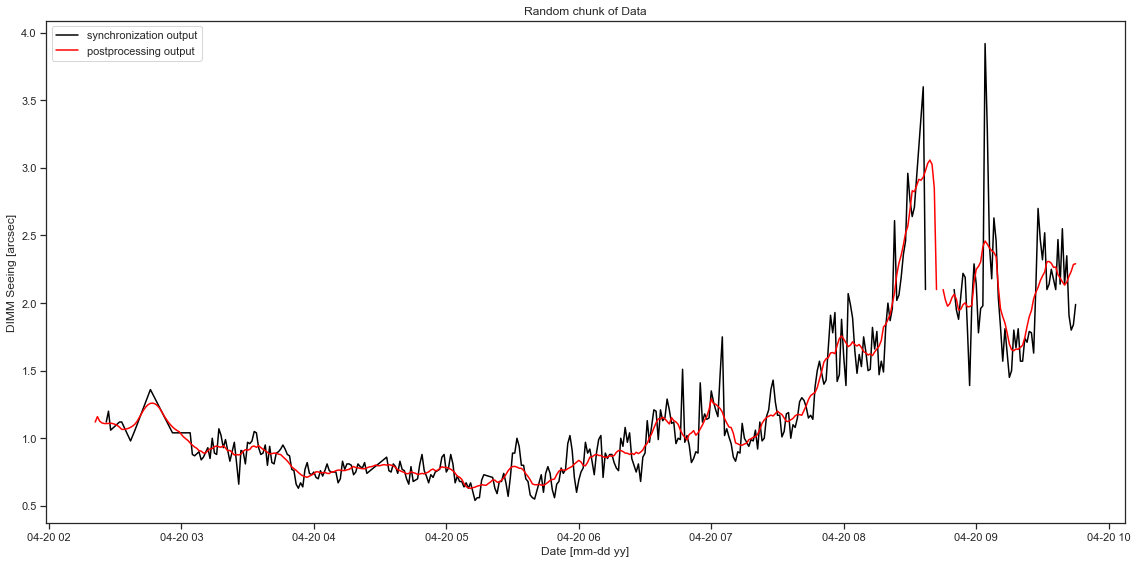

In [23]:
f, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(
    synced_df["DIMM Seeing [arcsec]"][1000:2000],
    label="synchronization output",
    color="black",
)
ax.plot(
    postproc_df["DIMM Seeing [arcsec]"][1000:2000],
    label="postprocessing output",
    color="red",
)
ax.set_xlabel("Date [mm-dd yy]")
ax.set_ylabel("DIMM Seeing [arcsec]")
ax.set_title("Random chunk of Data")
ax.legend()
f.set_tight_layout(True)
plt.show()

As we can see the "DIMM Seeing [arcsec]" field was indeed smoothed with our postprocessed run

#### Generating Additional Fields

After postprocessing our `RawFields`, we may decide to use these to generate new fields. We do this by configuring the `generated_fields` top level key of our `DataSet` config. 

```JSON
{
   "generated_fields":[
      {
         "target_name":"sin_t_sunset",
         "input_fields":[
            "index"
         ],
         "gen_func":"sin_t_since_sunset",
         "additional_kwargs":{
            "lat":-24.6275,
            "lon":-70.4044,
            "elevation":2635
         }
      }
   ],
   "postprocessing_output":{
      "output_format":"pickle",
      "output_path":"output/example_datapipe/postprocessed_df_genfields.pkl"
   },
   "sync_options":{
      "sample_spacing":60,
      "chunk_options":{
         "max_gap_size":600,
         "min_chunk_size":3600
      },
      "diagnostic_plots":false
   },
   "data_sources":[
      {
         "name":"lso_dimm",
         "path":"data/LSO/lasilla_dimm.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"DIMM Seeing [arcsec]",
               "postprocessing_options":{
                  "smooth_options":{
                     "window_size":10,
                     "units":"min"
                  }
               }
            }
         ],
         "comment_format":"#"
      },
      {
         "name":"lso_meteo",
         "path":"data/LSO/lasilla_meteo.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"Wind Speed at 10m [m/s]"
            },
            {
               "field_name":"Wind Direction at 10m [deg]"
            }
         ],
         "comment_format":"#"
      }
   ]
}
```

The `generated_fields` key contains a tuple (an array in JSON) of `GeneratedField` structs. Each one of these tells the pipeline how to generate new fields based on pre-implemented functions:

- `target_name` will be the name of the new field
- `input_field` is a tuple of the names of the fields to use as input to the
   generator function
- `gen_func` is the lowercase name of the function to use as identified by the
  `GeneratorFunction` enumeration struct.
- `additional_kwargs` is a dictionary of additional key-word arguments 
   necessary for the function.
   
In our case, we have configured our pipeline to generate one new field consisting in the sine of the seconds since the last sunset out of the number of seconds in teh day. This of course requires a temporal input which is why we pass our index. We also need to provide the pipeline with geographical information so that it knows where the sun horizon is.

Note -- at the moment, this function is _very_ slow. Please allow around 5 minutes for this operation alone. This is a known issue being tracked [here](https://gitlab.eso.org/gstarace/nowcastlib/-/issues/4)

#### Postprocessing Example Run 2

Generating additional fields is part of the `postprocess` CLI command. Simply specifying the additional configuration will let the pipeline know that we are interested in generating additional fields. Let's save the above config to the file `tutorial_pipeline_postprocess_genfields.json` and try it out.

---

In [24]:
!nowcastlib -v postprocess -c tutorial_pipeline_postprocess_genfields.json

2021-08-25 21:20:23,501 - INFO - Preprocessing dataset...
2021-08-25 21:20:23,502 - DEBUG - Preprocessing lso_dimm...
2021-08-25 21:20:23,502 - DEBUG - Reading file...
2021-08-25 21:20:24,905 - DEBUG - Processing field Date time of lso_dimm...
2021-08-25 21:20:24,905 - DEBUG - Processing field DIMM Seeing [arcsec] of lso_dimm...
2021-08-25 21:20:24,905 - DEBUG - Dropping NaNs...
2021-08-25 21:20:24,933 - DEBUG - Preprocessing lso_meteo...
2021-08-25 21:20:24,933 - DEBUG - Reading file...
2021-08-25 21:20:33,381 - DEBUG - Processing field Date time of lso_meteo...
2021-08-25 21:20:33,381 - DEBUG - Processing field Wind Speed at 10m [m/s] of lso_meteo...
2021-08-25 21:20:33,381 - DEBUG - Processing field Wind Direction at 10m [deg] of lso_meteo...
2021-08-25 21:20:33,381 - DEBUG - Dropping NaNs...
2021-08-25 21:20:33,522 - INFO - Dataset preprocessing complete.
2021-08-25 21:20:33,522 - INFO - Synchronizing dataset...
2021-08-25 21:20:33,522 - DEBUG - Resampling DataSource 1 of 2...
2021

---

Let's read our postprocessing (with additional generated fields) results and check that it worked.

In [25]:
genfield_df = pd.read_pickle("output/example_datapipe/postprocessed_df_genfields.pkl")

In [26]:
genfield_df[1900:2000]

,DIMM Seeing [arcsec],Wind Direction at 10m [deg],Wind Speed at 10m [m/s],sin_t_sunset
2005-04-20 08:06:00,1.682727,51.0,3.3,0.562985
2005-04-20 08:07:00,1.693636,51.0,3.3,0.559374
2005-04-20 08:08:00,1.670909,51.0,3.3,0.555752
2005-04-20 08:09:00,1.640909,51.0,3.3,0.552119
2005-04-20 08:10:00,1.631818,51.0,3.3,0.548476
...,...,...,...,...
2005-04-20 09:41:00,2.154545,60.0,2.5,0.182450
2005-04-20 09:42:00,2.199091,60.0,2.5,0.178158
2005-04-20 09:43:00,2.234545,60.0,2.5,0.173863
2005-04-20 09:44:00,2.285455,60.0,2.5,0.169565


As we can see, an additional column with the generated field has been added.

### Splitprocessing

Some operations require careful consideration of the data splitting intricacies to avoid information leakage across train and test sets. These operations, which we refer to as "splitprocessing", will therefore occur after we split our data. 

As such, data splitting options need to be configured for splitprocessing to occur.

Let's add add a top level `split_options` key to our most recent config, omitting additional generated fields for the sake of speed:

```JSON
{
   "split_options":{
      "train_split":0.8,
      "validation":{
         "train_extent":0.7,
         "val_extent":0.1,
         "iterations":3
      }
   },
   "postprocessing_output":{
      "output_format":"pickle",
      "output_path":"output/example_datapipe/postprocessed_df_genfields.pkl"
   },
   "sync_options":{
      "sample_spacing":60,
      "chunk_options":{
         "max_gap_size":600,
         "min_chunk_size":3600
      },
      "diagnostic_plots":false
   },
   "data_sources":[
      {
         "name":"lso_dimm",
         "path":"data/LSO/lasilla_dimm.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"DIMM Seeing [arcsec]",
               "postprocessing_options":{
                  "smooth_options":{
                     "window_size":10,
                     "units":"min"
                  }
               }
            }
         ],
         "comment_format":"#"
      },
      {
         "name":"lso_meteo",
         "path":"data/LSO/lasilla_meteo.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"Wind Speed at 10m [m/s]"
            },
            {
               "field_name":"Wind Direction at 10m [deg]"
            }
         ],
         "comment_format":"#"
      }
   ]
}
```

The way we split our data is determined by how we plan to evaluate it. The model training and evaluation subpipeline (not yet implemented) is made of two test harnesses:

- One for cross validation, using repeated holdout splits of the training set.
- One for model evaluation, using the actual test set.

From this, one infers that there is a nested splitting process involved in our pipeline. This is mirrored in the `split_options` configuration: 

- `train_split` specifies the percentage, index or date at which we wish to split our entire dataset into training and test sets. In our particular case, we are using 80% (0.8) of our dataset for training and cross validation, with the remaining 20% being left for the test set.
- We then split this 80% further for cross validation in "folds". This is to allow the user to gather statistics and metrics about the model performance without touching the test set and hence avoiding overfitting. This is what we refer to as cross validation. This is configured in the `validation` key.
    - `train_extent` is the percentage of the training data to use for each
       training fold
    - `val_extent` is the same but for each validation fold
    - to avoid overlap across folds, `train_extent + val_extent` should be  
      around 0.6 or 0.7, depending on the number of folds.
    - `iterations` corresponds to the number of folds.

#### Standardization

Before handing off our data for our models to train on, we may wish to standardize it. This is the process of rescaling or reshaping the data so that it falls into a smaller range or follows a different distribution. Certain algorithms assume their input to be Gaussian, while other algorithms simply perform better when their input is relatively small ($|x| < 1$) (e.g. vanishing/exploding gradients problem), so it is useful to be able to standardize the data to meet these requirements.

Some standardization methods make use of sample statistics to work and as such special care needs to be taken to avoid information leakage between train and test sets. This is why the nowcastlib pipeline splits the dataset before standardization

The `GeneratedField` and `RawField` structs share a common parent, the `BaseField` from which they inherit the `std_options` attribute. This key is used to tell the pipeline how to standardize our fields. Once again, let's only standardize one field ("DIMM Seeing [arcsec]") to keep things simple.

```JSON
   "split_options":{
      "train_split":0.8,
      "validation":{
         "train_extent":0.7,
         "val_extent":0.1,
         "iterations":3
      }
   },
   "postprocessing_output":{
      "output_format":"pickle",
      "output_path":"output/example_datapipe/postprocessed_df_genfields.pkl"
   },
   "sync_options":{
      "sample_spacing":60,
      "chunk_options":{
         "max_gap_size":600,
         "min_chunk_size":3600
      },
      "diagnostic_plots":false
   },
   "data_sources":[
      {
         "name":"lso_dimm",
         "path":"data/LSO/lasilla_dimm.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"DIMM Seeing [arcsec]",
               "postprocessing_options":{
                  "smooth_options":{
                     "window_size":10,
                     "units":"min"
                  }
               },
                "std_options":{
                  "method":"robust",
                  "diagnostic_plots":false
               }
            }
         ],
         "comment_format":"#"
      },
      {
         "name":"lso_meteo",
         "path":"data/LSO/lasilla_meteo.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"Wind Speed at 10m [m/s]"
            },
            {
               "field_name":"Wind Direction at 10m [deg]"
            }
         ],
         "comment_format":"#"
      }
   ]
}
```

The `std_options` key contains a `StandardizationOptions` struct:
- The `method` key takes a `StandardizationMethod` enumeration value. In this case we have chosen `robust`. This centers the distribution about its median and then rescales it using its interquartile range so to preserve the shape (including outliers) while keeping the data as close to the [-1, 1] range as possible.
- Setting the `diagnostic_plots` key to `true` will have the pipeline prompt
  the user to confirm their selected standardization method after viewing a 
  plot of the distributions of the data with each of the available methods
  applied as well as without any standardization. Once again, since we are
  running the pipeline as a terminal command from within Jupyter, interactive
  plots cannot be shown, and as such it is set to `false`.

#### Splitprocessing example run

With the config above, the result of splitting and standardizing will not be saved to disk. To do so, we need to specify the `output_options` key within our `SplitOptions` configuration. Let's also get rid of the `postprocessing_output` key since we are no longer interested in that.

```JSON
{
   "split_options":{
      "train_split":0.8,
      "validation":{
         "train_extent":0.7,
         "val_extent":0.1,
         "iterations":3
      },
      "output_options":{
         "parent_path":"output/example_datapipe/split_output",
         "overwrite":true,
         "create_parents":true
      }
   },
   "sync_options":{
      "sample_spacing":60,
      "chunk_options":{
         "max_gap_size":600,
         "min_chunk_size":3600
      },
      "diagnostic_plots":false
   },
   "data_sources":[
      {
         "name":"lso_dimm",
         "path":"data/LSO/lasilla_dimm.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"DIMM Seeing [arcsec]",
               "postprocessing_options":{
                  "smooth_options":{
                     "window_size":10,
                     "units":"min"
                  }
               },
               "std_options":{
                  "method":"robust",
                  "diagnostic_plots":false
               }
            }
         ],
         "comment_format":"#"
      },
      {
         "name":"lso_meteo",
         "path":"data/LSO/lasilla_meteo.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"Wind Speed at 10m [m/s]"
            },
            {
               "field_name":"Wind Direction at 10m [deg]"
            }
         ],
         "comment_format":"#"
      }
   ]
}
```

Let's save the above config to the file `tutorial_pipeline_splitprocess.json` and try it out. Some notes:

1. If we wanted to simply perform splitting without any standardization, all we would have to do is omit any standardization configuration, leaving in the split configuration. 
2. Running splitprocess on its own will not run postprocessing since the minimum requirement is a synchronized dataset. Instead it will run all processes up to and including synchronization before proceeding to splitprocessing.
3. The split serialization process is somewhat slow. Please allow a few minutes for it to complete.

---

In [27]:
!nowcastlib -v splitprocess -c tutorial_pipeline_splitprocess.json

2021-08-25 21:24:20,699 - INFO - Preprocessing dataset...
2021-08-25 21:24:20,699 - DEBUG - Preprocessing lso_dimm...
2021-08-25 21:24:20,699 - DEBUG - Reading file...
2021-08-25 21:24:22,423 - DEBUG - Processing field Date time of lso_dimm...
2021-08-25 21:24:22,423 - DEBUG - Processing field DIMM Seeing [arcsec] of lso_dimm...
2021-08-25 21:24:22,423 - DEBUG - Dropping NaNs...
2021-08-25 21:24:22,449 - DEBUG - Preprocessing lso_meteo...
2021-08-25 21:24:22,449 - DEBUG - Reading file...
2021-08-25 21:24:32,637 - DEBUG - Processing field Date time of lso_meteo...
2021-08-25 21:24:32,637 - DEBUG - Processing field Wind Speed at 10m [m/s] of lso_meteo...
2021-08-25 21:24:32,637 - DEBUG - Processing field Wind Direction at 10m [deg] of lso_meteo...
2021-08-25 21:24:32,638 - DEBUG - Dropping NaNs...
2021-08-25 21:24:32,782 - INFO - Dataset preprocessing complete.
2021-08-25 21:24:32,782 - INFO - Synchronizing dataset...
2021-08-25 21:24:32,782 - DEBUG - Resampling DataSource 1 of 2...
2021

---

Let's verify that our splits were serialized as configured:

In [28]:
!tree output/example_datapipe/split_output/

output/example_datapipe/split_output/
├── cv_split
│   ├── train_data_1.hdf5
│   ├── train_data_2.hdf5
│   ├── train_data_3.hdf5
│   ├── val_data_1.hdf5
│   ├── val_data_2.hdf5
│   └── val_data_3.hdf5
└── main_split
    ├── test_data.hdf5
    └── train_data.hdf5

2 directories, 8 files


As we can see, we have succesfully performed splitting.

### Running the pipeline as a whole

While the Nowcastlib Pipeline can be run in a somewhat modular (yet cascading) manner as shown in the above examples, the pipeline works best when run as a whole from start (preprocessing) to finish (splitting). In this way, certain redundant calculations are avoided. To do this, all we need to do is use the `datapipe` CLI command with a `DataSet` configuration specified as desired. 

For completeness, let's merge all or most of our example configurations above into a single configuration:

```JSON
{
   "generated_fields":[
      {
         "target_name":"sin_t_sunset",
         "input_fields":[
            "index"
         ],
         "gen_func":"sin_t_since_sunset",
         "additional_kwargs":{
            "lat":-24.6275,
            "lon":-70.4044,
            "elevation":2635
         }
      }
   ],
   "split_options":{
      "train_split":0.8,
      "validation":{
         "train_extent":0.7,
         "val_extent":0.1,
         "iterations":3
      },
      "output_options":{
         "parent_path":"output/example_datapipe/split_output_bigrun",
         "overwrite":true,
         "create_parents":true
      }
   },
   "postprocessing_output":{
      "output_format":"pickle",
      "output_path":"output/example_datapipe/postprocessed_df_bigrun.pkl"
   },
   "sync_options":{
      "sample_spacing":60,
      "chunk_options":{
         "max_gap_size":600,
         "min_chunk_size":3600
      },
      "diagnostic_plots":false,
      "data_output":{
         "output_format":"pickle",
         "output_path":"output/example_datapipe/synced_df_bigrun.pkl"
      },
      "chunks_output":{
         "output_format":"npy",
         "output_path":"output/example_datapipe/chunk_locs_bigrun.npy"
      }
   },
   "data_sources":[
      {
         "name":"lso_dimm",
         "path":"data/LSO/lasilla_dimm.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"DIMM Seeing [arcsec]",
               "preprocessing_options":{
                  "overwrite":false,
                  "outlier_options":{
                     "lower":0,
                     "upper":5,
                     "quantile_based":false
                  }
               },
               "postprocessing_options":{
                  "smooth_options":{
                     "window_size":10,
                     "units":"min"
                  }
               },
               "std_options":{
                  "method":"robust",
                  "diagnostic_plots":false
               }
            }
         ],
         "comment_format":"#"
      },
      {
         "name":"lso_meteo",
         "path":"data/LSO/lasilla_meteo.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"Wind Speed at 10m [m/s]"
            },
            {
               "field_name":"Wind Direction at 10m [deg]"
            }
         ],
         "comment_format":"#"
      }
   ]
}
```

Let's save the above config to the file `tutorial_pipeline.json` and give it a go. Note, this will take a few minutes due to the field generation and split serialization.

---

In [29]:
!nowcastlib -v datapipe -c tutorial_pipeline.json

2021-08-25 21:44:43,328 - INFO - Preprocessing dataset...
2021-08-25 21:44:43,328 - DEBUG - Preprocessing lso_dimm...
2021-08-25 21:44:43,328 - DEBUG - Reading file...
2021-08-25 21:44:44,679 - DEBUG - Processing field Date time of lso_dimm...
2021-08-25 21:44:44,679 - DEBUG - Processing field DIMM Seeing [arcsec] of lso_dimm...
2021-08-25 21:44:44,711 - DEBUG - Dropping outliers...
2021-08-25 21:44:44,898 - DEBUG - Dropping NaNs...
2021-08-25 21:44:44,952 - DEBUG - Preprocessing lso_meteo...
2021-08-25 21:44:44,952 - DEBUG - Reading file...
2021-08-25 21:44:54,100 - DEBUG - Processing field Date time of lso_meteo...
2021-08-25 21:44:54,100 - DEBUG - Processing field Wind Speed at 10m [m/s] of lso_meteo...
2021-08-25 21:44:54,100 - DEBUG - Processing field Wind Direction at 10m [deg] of lso_meteo...
2021-08-25 21:44:54,100 - DEBUG - Dropping NaNs...
2021-08-25 21:44:54,253 - INFO - Dataset preprocessing complete.
2021-08-25 21:44:54,253 - INFO - Synchronizing dataset...
2021-08-25 21:4

## Conclusion

The sections above will hopefully serve as a good introduction to the nowcastlib pipeline. Users are encouraged to experiment and read deeper into the documentation.